### 필수 라이브러리


In [2]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# .ensemble 메서드는 앙상블 학습 위주
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import( 
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split # .model_seclection 메서드는 모델의 성능 평가와 하이퍼파라미터튜닝
from tqdm import tqdm # 진행바 표시 라이브러리

### 데이터 로드

In [3]:
train = pd.read_csv(r'C:\Users\njh45\OneDrive\바탕 화면\2025_1\데이터애널리틱스\data.csv', encoding='utf-8-sig')
train.info()
list(train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   isbn              3316 non-null   int64  
 1   title             3316 non-null   object 
 2   publishDate       3316 non-null   object 
 3   price             3316 non-null   int64  
 4   pageCount         3316 non-null   int64  
 5   size              3296 non-null   float64
 6   weight            3316 non-null   int64  
 7   rating            3316 non-null   float64
 8   shortReviewCount  1440 non-null   float64
 9   fullReviewCount   1683 non-null   float64
 10  records           157 non-null    object 
 11  label             3316 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 311.0+ KB


['isbn',
 'title',
 'publishDate',
 'price',
 'pageCount',
 'size',
 'weight',
 'rating',
 'shortReviewCount',
 'fullReviewCount',
 'records',
 'label']

In [101]:
train.head(10)

,isbn,title,publishDate,price,pageCount,size,weight,rating,shortReviewCount,fullReviewCount,records,label
0,6000027854,스콜피언 1,2000-01-30,8000,270,31080.0,351,0.0,NaN,NaN,NaN,0
1,6000030199,으뜸글 평양아리,2001-06-09,5000,132,33896.0,185,0.0,NaN,NaN,NaN,0
2,6000040810,인간의 벽,1984-12-05,3400,345,31080.0,449,0.0,NaN,NaN,NaN,0
3,6000040811,황금깃털,1984-08-15,4000,334,31080.0,434,0.0,NaN,NaN,NaN,0
4,6000046295,태양과 그늘 1,2001-12-11,8000,304,33896.0,426,0.0,NaN,NaN,NaN,0
5,6000072470,지독한 사랑,2001-12-19,7500,258,33896.0,361,0.0,NaN,NaN,NaN,0
6,6000098996,대물 2,1996-12-15,6500,306,31080.0,398,0.0,NaN,NaN,NaN,0
7,6000106070,백록담 연가,2000-11-05,7500,278,33896.0,389,0.0,NaN,NaN,NaN,0
8,6000585358,뿌리 깊은 나무 1,2006-07-18,9500,292,33896.0,409,8.9,69.0,100.0,NaN,0
9,6000644839,[세트] 황태자비 납치사건 + 천년의 금서 - 전2권,2010-03-01,24600,102,24123.0,143,0.0,NaN,NaN,NaN,0


### 필수 전처리

In [4]:
## 2025-04-28 기준으로 날짜의 차이를 계산

train['publishDate'] = pd.to_datetime(train['publishDate'])

# 기준일 설정
reference_date = pd.to_datetime('2025-04-28')

# 날짜 차이(일수) 계산해서 새로운 컬럼으로 저장
train['publishDate'] = (reference_date - train['publishDate']).dt.days

## 결측치

In [115]:
# 결측치가 있는 열들만 추출하고 결측치 개수 계산
missing_data = train.isnull().sum() # ,isnull()는 value가 결측값이면 True 아니면 False 반환
missing_columns = missing_data[missing_data > 0]

# 결과 출력
print("결측치가 있는 컬럼들:")
print(missing_columns)

결측치가 있는 컬럼들:
size                  20
shortReviewCount    1876
fullReviewCount     1633
records             3159
dtype: int64


### [size]

In [5]:
# pageCount ±10, price ±1000 차이 나는 책들 중 size 평균으로 대체
def impute_size(row):
    if pd.isna(row['size']):
        similar_books = train[
            (abs(train['pageCount'] - row['pageCount']) <= 10) &
            (abs(train['price'] - row['price']) <= 1000) &
            (~train['size'].isna())
        ]
        if not similar_books.empty:
            return similar_books['size'].mean()
    return row['size']

train['size'] = train.apply(impute_size, axis=1)

In [6]:
# 위 범위에 해당되지 않는 책 확인
train[train['size'].isna()]

,isbn,title,publishDate,price,pageCount,size,weight,rating,shortReviewCount,fullReviewCount,records,label
597,9788964891469,붉은달,4619,13000,714,NaN,643,8.0,NaN,1.0,NaN,0


In [7]:
# price=13000, pageCount=714인 책을 위한 size 결측치 대체
condition_book = train[
    (abs(train['pageCount'] - 714) <= 100) &
    (abs(train['price'] - 13000) <= 10000) &
    (~train['size'].isna())
]

# 평균 구해서 대입
if not condition_book.empty:
    size_mean = condition_book['size'].mean()
    train.loc[(train['pageCount'] == 714) & (train['price'] == 13000), 'size'] = size_mean

In [8]:
train[train['isbn'] == 9788964891469]

,isbn,title,publishDate,price,pageCount,size,weight,rating,shortReviewCount,fullReviewCount,records,label
597,9788964891469,붉은달,4619,13000,714,29758.833333,643,8.0,NaN,1.0,NaN,0


### [shortReviewCount] [fullReviewCount]

추후에 present 파생변수 조절해가며 피처 중요도 비교

In [9]:
# 리뷰 존재 여부를 파생변수로 저장 (결측이 아닌 경우 1, 결측이면 0)
train['shortReview_present'] = train['shortReviewCount'].notna().astype(int)
train['fullReview_present'] = train['fullReviewCount'].notna().astype(int) * 2

# 실제 리뷰 수는 없으니까까 0으로 대체
train['shortReviewCount'].fillna(0, inplace=True)
train['fullReviewCount'].fillna(0, inplace=True)

C:\Users\njh45\AppData\Local\Temp\ipykernel_30708\2939937977.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['shortReviewCount'].fillna(0, inplace=True)
C:\Users\njh45\AppData\Local\Temp\ipykernel_30708\2939937977.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [109]:
print(train['shortReview_present'].head(9))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
Name: shortReview_present, dtype: int32


### [records]

In [110]:
train[train['records'].notna()].head(6)

,isbn,title,publishDate,price,pageCount,size,weight,rating,shortReviewCount,fullReviewCount,records,label,publishDate_diff_days,shortReview_present,fullReview_present
798,9788974563622,반야 1,2007-04-25,9800,336,33896.0,470,8.1,2.0,24.0,"멜로·로맨스 주간 1위, 소설/시/희곡 top100 5주",0,6578,1,2
1814,9791162101049,"안녕, 나의 우주",2021-03-31,13000,224,31080.0,316,9.7,1.0,18.0,대체역사/가상소설 주간 6위,0,1489,1,2
2326,9788932013046,그대의 차가운 손,2002-01-18,14000,329,33896.0,461,8.4,7.0,28.0,"한국소설 주간 41위, 종합 top100 3주",1,8501,1,2
2331,9788932020006,"바람이 분다, 가라",2010-02-26,14000,390,31080.0,507,9.0,43.0,44.0,"소설/시/희곡 주간 35위, 종합 top10 3주",1,5540,1,2
2341,9788932034829,내 여자의 열매,2018-11-09,14000,406,25350.0,461,8.9,4.0,7.0,"한국소설 주간 37위, 종합 top100 5주",1,2362,1,2
2342,9788932034836,노랑무늬영원,2018-11-09,14000,308,25350.0,356,9.5,8.0,8.0,"달력/기타 주간 1위, 종합 top100 5주",1,2362,1,2


In [10]:
# 원핫인코딩 후 스케일링
train['has_records'] = train['records'].notna().astype(int)
train['has_records'] *= 3

# 기존 records 컬럼 제거
train.drop(columns=['records'], inplace=True)

## 이상치

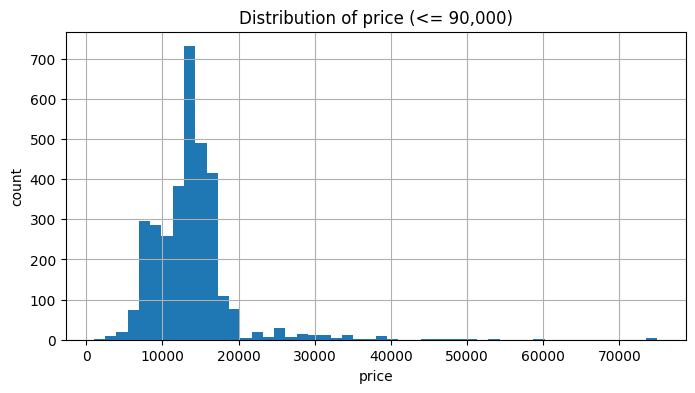

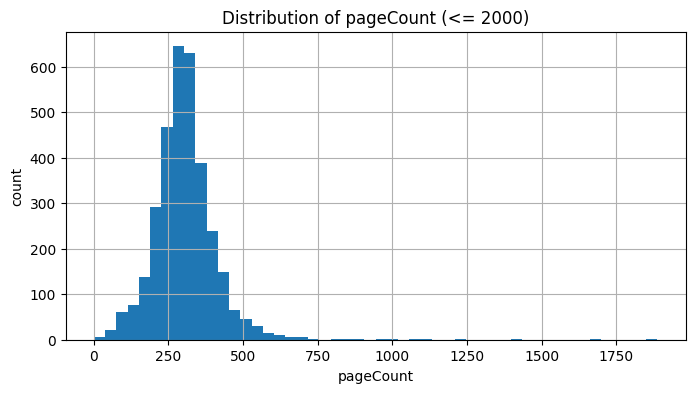

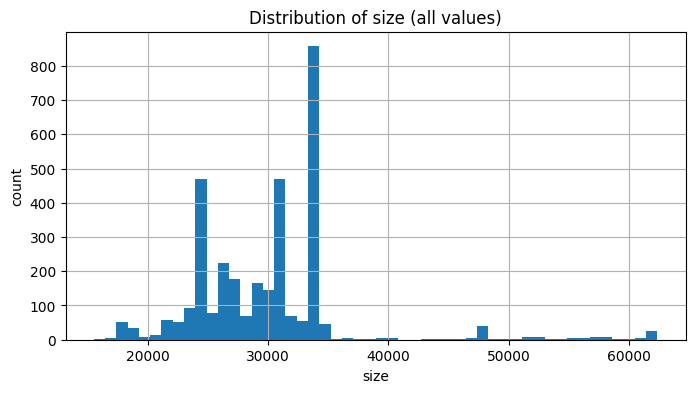

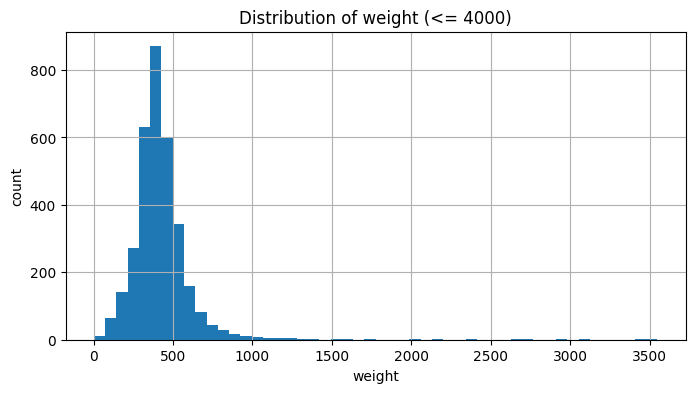

In [ ]:
## 의미가 비슷한 컬럼들 우선 시각화

# price
plt.figure(figsize=(8,4))
train[train['price'] <= 90000]['price'].hist(bins=50)
plt.title('Distribution of price (<= 90,000)')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

# pageCount
plt.figure(figsize=(8,4))
train[train['pageCount'] <= 2000]['pageCount'].hist(bins=50)
plt.title('Distribution of pageCount (<= 2000)')
plt.xlabel('pageCount')
plt.ylabel('count')
plt.show()

# size
plt.figure(figsize=(8,4))
train['size'].hist(bins=50)
plt.title('Distribution of size (all values)')
plt.xlabel('size')
plt.ylabel('count')
plt.show()

# weight
plt.figure(figsize=(8,4))
train[train['weight'] <= 4000]['weight'].hist(bins=50)
plt.title('Distribution of weight (<= 4000)')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

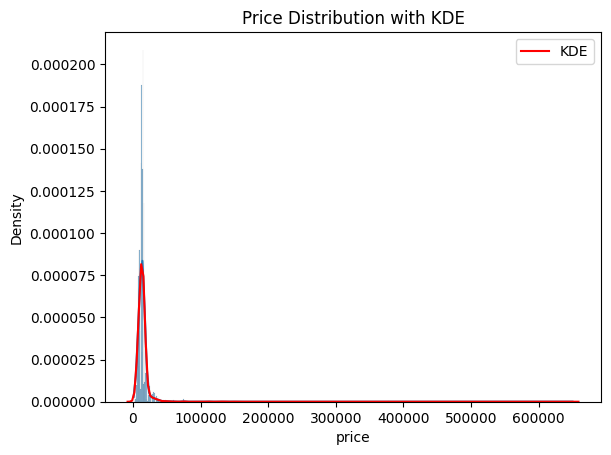

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.histplot(train['price'], kde=True, stat='density')
sns.kdeplot(train['price'], color='red', label='KDE')
plt.title("Price Distribution with KDE")
plt.legend()
plt.show()

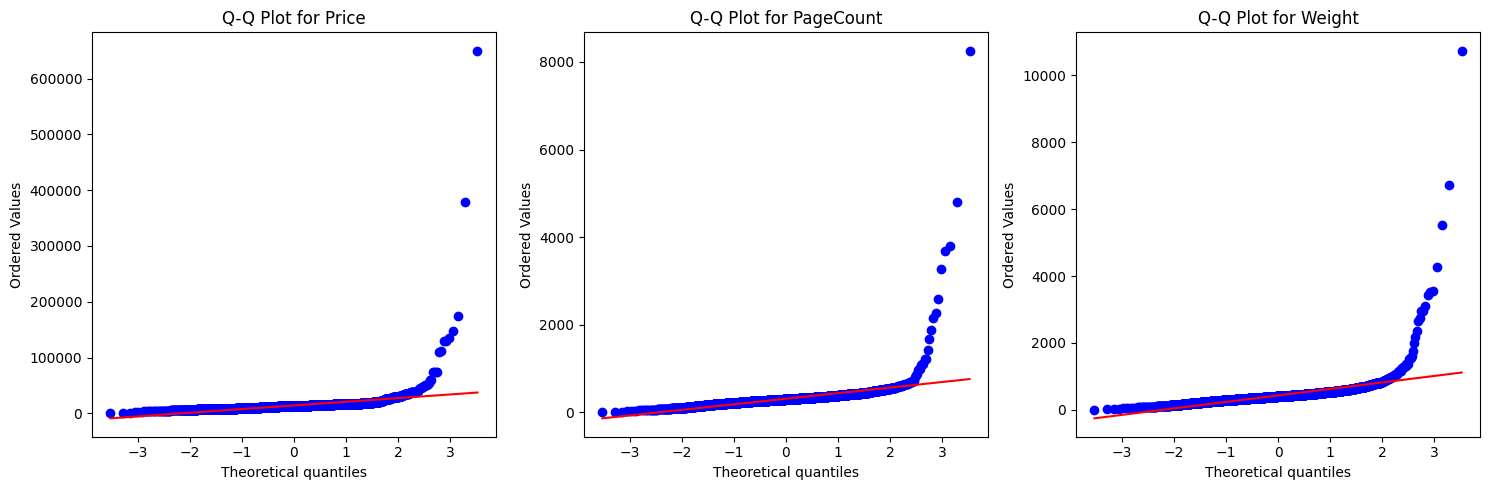

In [82]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# 플롯 크기 설정
plt.figure(figsize=(15, 5))

# price
plt.subplot(1, 3, 1)
stats.probplot(train['price'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Price")

# pageCount
plt.subplot(1, 3, 2)
stats.probplot(train['pageCount'], dist="norm", plot=plt)
plt.title("Q-Q Plot for PageCount")

# weight
plt.subplot(1, 3, 3)
stats.probplot(train['weight'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Weight")

plt.tight_layout()
plt.show()

In [84]:
from scipy.stats import shapiro

stat, p = shapiro(train['price'])
print(f"Shapiro-Wilk Test Statistic={stat}, p-value={p}")

if p > 0.05:
    print("정규분포")
else:
    print("정규분포가 아님")

Shapiro-Wilk Test Statistic=0.1931571823524718, p-value=1.8885826971932393e-80
정규분포가 아님


# ligm

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isbn                 3316 non-null   int64  
 1   title                3316 non-null   object 
 2   publishDate          3316 non-null   int64  
 3   price                3316 non-null   int64  
 4   pageCount            3316 non-null   int64  
 5   size                 3316 non-null   float64
 6   weight               3316 non-null   int64  
 7   rating               3316 non-null   float64
 8   shortReviewCount     3316 non-null   float64
 9   fullReviewCount      3316 non-null   float64
 10  label                3316 non-null   int64  
 11  shortReview_present  3316 non-null   int32  
 12  fullReview_present   3316 non-null   int32  
 13  has_records          3316 non-null   int32  
dtypes: float64(4), int32(3), int64(6), object(1)
memory usage: 324.0+ KB


In [13]:
import lightgbm
print(lightgbm.__version__)

4.6.0


In [20]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 사용하지 않을 컬럼 제거
drop_cols = ['isbn', 'title']
X = train.drop(columns=drop_cols + ['label'])
y = train['label']

# 데이터 분할 (8:2)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# LGBM 모델 정의
model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_estimators=1000
)

# 학습
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

# 예측 및 평가
y_pred = model.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred))


[LightGBM] [Info] Number of positive: 800, number of negative: 1852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301659 -> initscore=-0.839410
[LightGBM] [Info] Start training from score -0.839410
Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.114856
[100]	valid_0's binary_logloss: 0.113732
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.109947
[[450  14]
 [ 15 185]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       464
           1       0.93      0.93      0.93       200

    accuracy                           0.96       664
   macro avg       0.95      0.95      0.95       66

피처 중요도

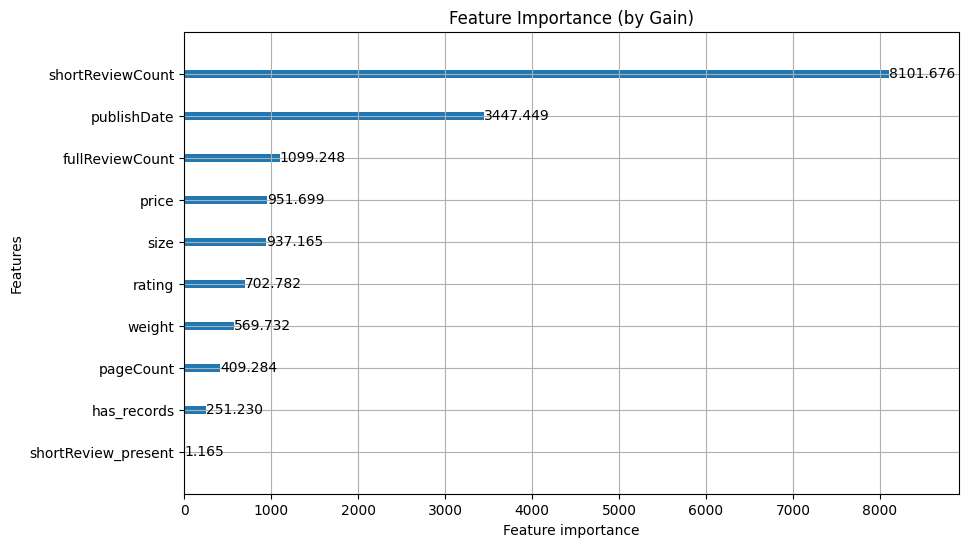

In [15]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# 피처 중요도 출력
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (by Gain)")
plt.show()

SHAP

C:\Users\njh45\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


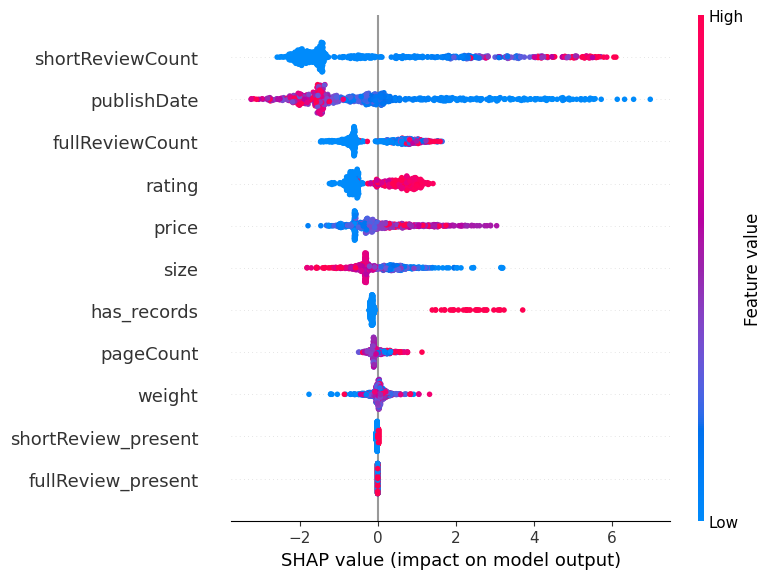

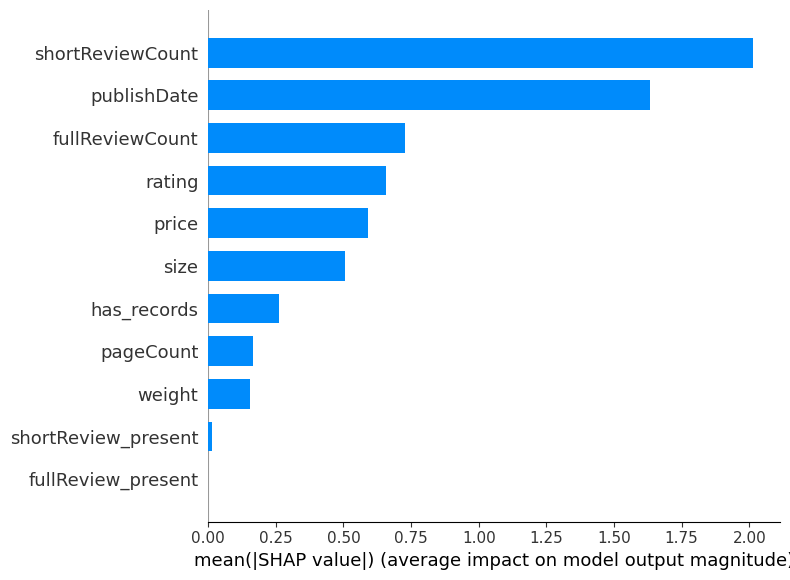

In [16]:
import shap

# Tree Explainer를 기반으로 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

# 전체 요약 플롯
shap.summary_plot(shap_values, X_valid, plot_type="dot")

# bar 형태로 평균적인 feature 중요도 확인
shap.summary_plot(shap_values, X_valid, plot_type="bar")
